# References

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/

https://github.com/ritchieng/deep-learning-wizard/tree/v1.0.1

In [1]:
import os
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets # CIFAR10, MNIST
import pytorch_lightning as pl

import matplotlib.pyplot as plt

# STEP1 - Datasets

## CIFAR-10 dataset. 
The dataset contains 10 classes and has 60.000 32 by 32 pixel images, with 6000 images per class.

ds_cifar = datasets.CIFAR10(
    '../data/cifar10', 
    download=True, 
    transform=transforms.ToTensor())

## Mnist 

In [2]:
# Load data set
# https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html

t_mnist = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

ds_mnist_train = datasets.MNIST(
    '../data/mnist', 
    download=True, 
    train=True, 
    transform=transforms.ToTensor())
ds_mnist_test = datasets.MNIST(
    '../data/mnist', 
    download=True, 
    train=False, 
    transform=transforms.ToTensor())



## Fashion Mnist

In [3]:
ds_fashion_train = datasets.FashionMNIST(
    root="../data/fashionmnist",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

ds_fashion_test = datasets.FashionMNIST(
    root="../data/fashionmnist",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

## Selecting and Visualizing Dataset

In [4]:
# https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html

ds_train = ds_mnist_train
ds_test = ds_mnist_test
ds_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data/mnist
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

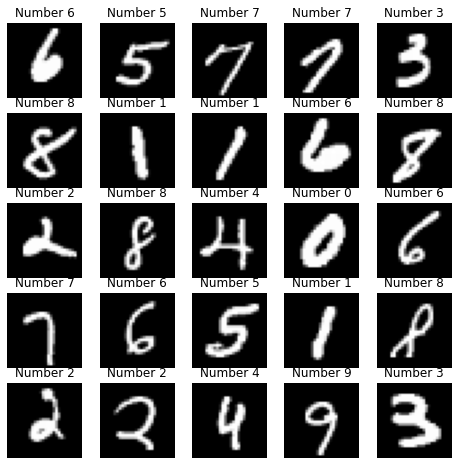

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(ds_train.data.shape[0], size=(1,)).item()

    img = ds_train.data[sample_idx]
    label = ds_train.targets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

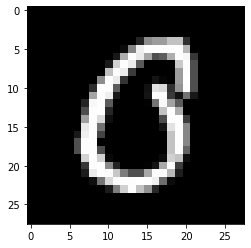

In [6]:
image = ds_train.data[234]
plt.imshow(image.squeeze(), cmap="gray")

# STEP2 - Making dataset iterable with Data loader

## Selection of validation set

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# percentage of training set to use as validation
valid_size = 0.2

# Here we will use a subset of traning set for validation
# obtain training indices that will be used for validation
num_train = len(ds_train)
ix = list(range(num_train))
np.random.shuffle(ix)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = ix[split:], ix[:split]

# create sampler objects using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
# Prepare training data loader

# how many samples per batch to load
batch_size = 100

loaders = {
    'train' : torch.utils.data.DataLoader(ds_train, sampler=train_sampler, 
                                          batch_size=batch_size, 
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(ds_train, sampler=valid_sampler, 
                                          batch_size=batch_size, 
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(ds_test, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f56883dd760>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f56883dd880>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f56883dddf0>}

In [9]:
# Let's check the shape of the input/target data
for data, target in loaders['train']:
    print(data.shape)
    print(target.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


# STEP 3 - Defining model : simple MLP

In [10]:
# pytorch

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

class MLP_Mnist(nn.Module):                   # the one selected for mnist
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 100),
      nn.Sigmoid(),
      nn.Linear(100, 100),
      nn.Sigmoid(),                   # nn.ReLU(),
      nn.Linear(100, 10)
    )

    # custom weight initialization
    nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
    for layer in nnLinearLayers:
      nn.init.normal_(layer.weight)


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

class MLP_Cifar10(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

## Choosing model

In [20]:
model = MLP_Mnist()

## parameters

In [12]:
print(list(model.layers))
print([layer for layer in model.layers if type(layer) == nn.Linear])
print(model.layers[1])
# nn.init.normal_(model.layers[1].weight)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=100, bias=True), Sigmoid(), Linear(in_features=100, out_features=100, bias=True), Sigmoid(), Linear(in_features=100, out_features=10, bias=True)]
[Linear(in_features=784, out_features=100, bias=True), Linear(in_features=100, out_features=100, bias=True), Linear(in_features=100, out_features=10, bias=True)]
Linear(in_features=784, out_features=100, bias=True)


In [13]:
# FC 1 Parameters 
print(list(model.parameters())[0].size())  # A1
print(list(model.parameters())[1].size())  # Bias1
print(list(model.parameters())[2].size())
print(list(model.parameters())[3].size())
print(list(model.parameters())[4].size())

torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([10, 100])


# Optimizer

In [21]:
learning_rate = 0.1
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate)

optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-4)

## Choosing optimizer

In [22]:
optimizer = optimizer_SGD

# Weights initializations

https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/   

By default, PyTorch uses Lecun initialization (http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)    

https://www.aritrasen.com/deep-learning-with-pytorch-custom-weight-initialization-1-5/   
Very good vizualizaton of why weight initialization plays an important part in the performance of neural networks.

# Train model

## Train model - 1 -  With Pytorch

In [16]:
ds_train.data.size()[0]

60000

In [17]:
batch_size

100

In [18]:
# what is coming out of enumerating a data loader ? ==> mini-batches of X and y

bla = enumerate(loaders['train'])

i, data = next(bla)

inputs, targets = data

print('Data input type:', type(inputs))
print('... size:', inputs.size())
print('target type:', type(targets))
print('... size:', targets.size())

Data input type: <class 'torch.Tensor'>
... size: torch.Size([100, 1, 28, 28])
target type: <class 'torch.Tensor'>
... size: torch.Size([100])


In [19]:
# https://programming-review.com/pytorch/mnist

from sklearn.metrics import accuracy_score, f1_score
num_epochs=10
lossFunction = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    total_samples_processed = 0

    ## training part 
    ## ------------
    model.train()

    for minibatch, (images, labels) in enumerate(loaders['train']):   # enumerate minibatches
        # Load images with gradient accumulation capabilities
        # https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
        # https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = lossFunction(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_samples_processed += 100
        if minibatch % 100 == 99:
            print('Average minibatch loss after {} mini-batches of {}: {:.3f}'.format(minibatch+1, batch_size, current_loss / 500))
            print(f'... total samples processed in this epoch so far: {total_samples_processed}')
            current_loss = 0.0


    # Calculate Accuracy using test set at the end of each epoch      
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in loaders['test']:
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / total

    # Print Loss
    print('Epoch completed: {}. Last minibatch Loss: {}. Accuracy: {}'.format(epoch+1, loss.item(), accuracy))

Starting epoch 1
Average minibatch loss after 100 mini-batches of 100: 0.613
... total samples processed in this epoch so far: 10000
Average minibatch loss after 200 mini-batches of 100: 0.317
... total samples processed in this epoch so far: 20000
Average minibatch loss after 300 mini-batches of 100: 0.245
... total samples processed in this epoch so far: 30000
Average minibatch loss after 400 mini-batches of 100: 0.216
... total samples processed in this epoch so far: 40000
Epoch completed: 1. Last minibatch Loss: 0.9577377438545227. Accuracy: 71.41999816894531
Starting epoch 2
Average minibatch loss after 100 mini-batches of 100: 0.175
... total samples processed in this epoch so far: 10000
Average minibatch loss after 200 mini-batches of 100: 0.166
... total samples processed in this epoch so far: 20000
Average minibatch loss after 300 mini-batches of 100: 0.156
... total samples processed in this epoch so far: 30000
Average minibatch loss after 400 mini-batches of 100: 0.149
... t

KeyboardInterrupt: 

## Train model - 2 -  With Pytorch

In [ ]:
### if running as a script : if __name__ == '__main__':


# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()


# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
  
  # Print epoch
  print(f'Starting epoch {epoch+1}')
  
  # Set current loss value
  current_loss = 0.0
  
  # Iterate over the DataLoader for training data
  for i, data in enumerate(loaders['train'], 0):

    # Dataset mnist : __getitem__ returns tuple: (image, target) where target is index of the target class.
    
    # Get inputs
    inputs, targets = data
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Perform forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = loss_function(outputs, targets)
    
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()
    
    # Print statistics
    current_loss += loss.item()
    if i % 500 == 499:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / 500))
        current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 0.373
Starting epoch 2
Loss after mini-batch   500: 0.344
Starting epoch 3
Loss after mini-batch   500: 0.315
Starting epoch 4
Loss after mini-batch   500: 0.296
Starting epoch 5
Loss after mini-batch   500: 0.278
Training process has finished.


## Train model - 3 - With validation data set

In [ ]:
# https://programming-review.com/pytorch/mnist

from sklearn.metrics import accuracy_score, f1_score
epochs=10

for epoch in range(1, epochs+1): ## run the model for 11 epochs
    train_loss, valid_loss = [], []
    ## training part 
    ##--------------
    model.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = lossFunction(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    ## evaluation part
    ## ---------------

    with torch.no_grad():  #gradients should not evaluate
        model.eval()
        for data, target in loaders['valid']:
            output = model(data)
            loss = lossFunction(output, target)
            valid_loss.append(loss.item())
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))

Epoch: 1 Training Loss:  1.8167495008558034 Valid Loss:  1.037924225628376
Epoch: 2 Training Loss:  0.8870147830496232 Valid Loss:  0.763156830271085
Epoch: 3 Training Loss:  0.6982357770825426 Valid Loss:  0.6465286801258723
Epoch: 4 Training Loss:  0.6010269952937961 Valid Loss:  0.5777931553622087
Epoch: 5 Training Loss:  0.5401385661835472 Valid Loss:  0.534806260963281
Epoch: 6 Training Loss:  0.49684652605404456 Valid Loss:  0.49848102827866875
Epoch: 7 Training Loss:  0.463507203788807 Valid Loss:  0.4713262651115656
Epoch: 8 Training Loss:  0.43742580196509756 Valid Loss:  0.44823066393534344
Epoch: 9 Training Loss:  0.41555182660619416 Valid Loss:  0.43298034158845744
Epoch: 10 Training Loss:  0.39702073369796076 Valid Loss:  0.41988775779803594


## Train model - 4 -  With Pytorch LIghtning

In [ ]:
# https://www.machinecurve.com/index.php/2021/01/26/creating-a-multilayer-perceptron-with-pytorch-and-lightning/

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(28*28, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
    )
    self.ce = nn.CrossEntropyLoss()
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.layers(x)
    loss = self.ce(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [ ]:
if __name__ == '__main__':
  dataset = ds_train
  pl.seed_everything(42)
  mlp = MLP()
  trainer = pl.Trainer(auto_scale_batch_size='power', gpus=0, deterministic=True, max_epochs=5)
  trainer.fit(mlp, DataLoader(dataset))

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 89.6 K
1 | ce     | CrossEntropyLoss | 0     
--------------------------------------------
89.6 K    Trainable params
0         Non-trainable params
89.6 K    Total params
0.358     Total estimated model params size (MB)
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_war

Training: -1it [00:00, ?it/s]

# Results

In [ ]:
print(model)

MLP_Mnist(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)
